## LG 18650HG2 Li-ion Battery SOC Prediction - Convolutional Neural Network (CNN)
LG 18650HG2 Li-ion Battery Data - https://data.mendeley.com/datasets/cp3473x7xv/3

Kollmeyer, Philip; Vidal, Carlos; Naguib, Mina; Skells, Michael  (2020), “LG 18650HG2 Li-ion Battery Data and Example Deep Neural Network xEV SOC Estimator Script”, Mendeley Data, V3, doi: 10.17632/cp3473x7xv.3

### CNN Architecture and Data Processing
The Jupyter notebook code initializes a neural network for State of Charge (SoC) estimation, employing a CNN-based approach. The SoCCNN1D model consists of an input layer, several hidden convolutional layers with ReLU activations, batch normalization, and dropout to prevent overfitting. The data is segmented into training, validation, and testing sets, prepped for model training and assessment. The train_and_validate function orchestrates the training process across epochs, monitoring both training and validation losses.

In [11]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.preprocessing import MinMaxScaler
from torch.profiler import profile, ProfilerActivity
import time 
from torch.cuda.amp import GradScaler, autocast 

# Check if the environment variable is set to 'True'
skip_training = os.getenv('SKIP_TRAINING', 'False') == 'True'
skip_optuna = os.getenv('SKIP_OPTUNA', 'False') == 'True'

PROCESSED_DATA_DIR = '../dataset/LG_HG2_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'CC_Capacity [Ah]']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']

                    # Initialize CC_Capacity [Ah] column
                    df['CC_Capacity [Ah]'] = 0.0

                    # Integrating current over time to calculate cumulative capacity
                    df['CC_Capacity [Ah]'] = (df['Current [A]'] * df['Time [s]'].diff().fillna(0) / 3600).cumsum()

                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

class BatteryDatasetCNN1D(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].unsqueeze(1)
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

# CNN Model
class SoCCNN1D(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_layers, kernel_size=3, dropout=0.1):
        super(SoCCNN1D, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First convolutional layer
        self.conv_layers.append(nn.Conv1d(input_channels, hidden_channels, kernel_size, padding=kernel_size//2))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_channels))

        # Dynamically add convolutional layers
        for i in range(1, num_layers):
            layer_channels = hidden_channels // (2 ** i)
            self.conv_layers.append(nn.Conv1d(hidden_channels // (2 ** (i - 1)), layer_channels, kernel_size, padding=kernel_size//2))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_channels))

        # Output layer - adjust as needed
        self.output_layer = nn.Conv1d(hidden_channels // (2 ** (num_layers - 1)), 1, kernel_size, padding=kernel_size//2)

        # Activation and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for conv_layer, batch_norm_layer in zip(self.conv_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(conv_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        x = x.squeeze()
        return x


# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        total_iterations = len(train_loader)
        epoch_start_time = time.time()
        for sequences, labels, _, _ in train_loader:  
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels) 
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

temperatures_to_process = ['25degC', '0degC', 'n10degC', 'n20degC', '10degC', '40degC']   
# temperatures_to_process = ['25degC', '0degC', 'n10degC', '10degC'] 
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)

# Apply a moving average filter to your features
#window_size = 5 
#smoothed_data = data[FEATURE_COLS].rolling(window=window_size, min_periods=1).mean()
# Replace the original features with the smoothed features
#data[FEATURE_COLS] = smoothed_data

scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])

unique_files = np.array(list(set(data['SourceFile'])))

# Convert to tensors and load into GPU memory
data_tensor = torch.tensor(data[FEATURE_COLS].values, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(data[LABEL_COL].values, dtype=torch.float32).to(device)
filenames_tensor = data['SourceFile'].values

unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)


# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetCNN1D(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetCNN1D(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetCNN1D(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'589_Mixed1_processed.csv', '562_Mixed5_processed.csv', '552_Cap_1C_processed.csv', '610_Cap_1C_processed.csv', '611_Mixed7_processed.csv', '589_UDDS_processed.csv', '576_HWFET_processed.csv', '601_Mixed1_processed.csv', '593_HPPC_processed.csv', '556_Mixed2_processed.csv', '557_Cap_1C_processed.csv', '611_Cap_1C_processed.csv', '590_Mixed7_processed.csv', '590_Mixed6_processed.csv', '590_Mixed8_processed.csv', '589_HWFET_processed.csv', '552_Mixed5_processed.csv', '576_Cap_1C_processed.csv', '552_Mixed8_processed.csv', '610_UDDS_processed.csv', '571_Mixed7_processed.csv', '567_Mixed2_processed.csv', '557_Mixed3_processed.csv', '552_Mixed4_processed.csv', '604_Mixed3_processed.csv', '611_Mixed3_processed.csv', '556_LA92_processed.csv', '610_HWFET_processed.csv', '611_Mixed6_processed.csv', '604_Mixed6_processed.csv', '549_HPPC_processed.csv', '555_HPPC_processed.csv', '571_Mixed8_processed.csv', '551_US06_processed.csv', '611_Mixed8_processed.csv', '604_Mixed8_processe

In [12]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([430079, 5])
Test features shape: torch.Size([49380, 5])
Train labels shape: torch.Size([430079])
Test labels shape: torch.Size([49380])


### Hyperparameter tuning

This neural network setup uses Optuna for hyperparameter tuning to optimize the learning rate, hidden layer size, number of layers, and dropout rate of a SoCCNN1D model. The objective function defines and trains the model, returning the validation loss as a target to minimize. After tuning, the best hyperparameters are printed, and Optuna's visualization tools are used to display the optimization history and parameter importance, aiding in understanding the influence of each hyperparameter.

[I 2024-01-22 10:24:17,375] A new study created in memory with name: no-name-b7be5f9b-99e8-4182-b87f-6163a82fc98d


Epoch 1/10, Train Loss: 0.027368744249197923, Validation Loss: 0.03201199833279487
Time taken for epoch: 78.95931816 seconds
Epoch 2/10, Train Loss: 0.025448286080845303, Validation Loss: 0.5411568505727087
Time taken for epoch: 88.16450572 seconds
Epoch 3/10, Train Loss: 0.02518190506482072, Validation Loss: 0.017236891609931443
Time taken for epoch: 88.86016369 seconds
Epoch 4/10, Train Loss: 0.025364024663360237, Validation Loss: 0.012633983461738245
Time taken for epoch: 93.53555155 seconds
Epoch 5/10, Train Loss: 0.025334331314448413, Validation Loss: 0.012921281034968929
Time taken for epoch: 90.09395456 seconds
Epoch 6/10, Train Loss: 0.02533928919200632, Validation Loss: 0.022833075826843966
Time taken for epoch: 92.06410933 seconds
Epoch 7/10, Train Loss: 0.02499008272262458, Validation Loss: 0.008582366510675626
Time taken for epoch: 95.12634683 seconds
Epoch 8/10, Train Loss: 0.025644512470497996, Validation Loss: 0.024056146912240076
Time taken for epoch: 96.90770793 second

[I 2024-01-22 10:43:08,498] Trial 0 finished with value: 0.0556118959400115 and parameters: {'learning_rate': 0.09180704091388472, 'hidden_size': 264, 'num_layers': 2, 'dropout_rate': 0.31563803066811486}. Best is trial 0 with value: 0.0556118959400115.


Epoch 10/10, Train Loss: 0.025484175766490643, Validation Loss: 0.0556118959400115
Time taken for epoch: 157.93605161 seconds
Epoch 1/10, Train Loss: 0.011162438977379487, Validation Loss: 0.0025829194162771815
Time taken for epoch: 52.21907401 seconds
Epoch 2/10, Train Loss: 0.012094598876708997, Validation Loss: 0.0036797166003410026
Time taken for epoch: 51.03767681 seconds
Epoch 3/10, Train Loss: 0.01125477478298049, Validation Loss: 0.004945692019794279
Time taken for epoch: 55.03770137 seconds
Epoch 4/10, Train Loss: 0.012382991230637975, Validation Loss: 0.008679868928825453
Time taken for epoch: 54.08258963 seconds
Epoch 5/10, Train Loss: 0.012444659091479402, Validation Loss: 0.010168319746390054
Time taken for epoch: 54.44776845 seconds
Epoch 6/10, Train Loss: 0.012551987475187586, Validation Loss: 0.009967983850257923
Time taken for epoch: 52.94028234 seconds
Early stopping triggered
Epoch 7/10, Train Loss: 0.012635295458069788, Validation Loss: 0.010282101218336014
Time tak

[I 2024-01-22 10:53:09,085] Trial 1 finished with value: 0.005576482151021071 and parameters: {'learning_rate': 0.05321510725230377, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.2562907770421737}. Best is trial 1 with value: 0.005576482151021071.


Epoch 10/10, Train Loss: 0.013398385826539638, Validation Loss: 0.005576482151021071
Time taken for epoch: 55.67341042 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.004429119889119065, Validation Loss: 0.0010351243272260424
Time taken for epoch: 53.78998065 seconds
Epoch 2/10, Train Loss: 0.003710305251145558, Validation Loss: 0.0023179121089712536
Time taken for epoch: 54.54772735 seconds
Epoch 3/10, Train Loss: 0.0036619648652055914, Validation Loss: 0.0009748542430851509
Time taken for epoch: 54.85547471 seconds
Epoch 4/10, Train Loss: 0.0036833678535332496, Validation Loss: 0.0008900562734867147
Time taken for epoch: 56.08061004 seconds
Epoch 5/10, Train Loss: 0.003659625631241527, Validation Loss: 0.0005114742066572964
Time taken for epoch: 55.31806731 seconds
Epoch 6/10, Train Loss: 0.00369020344640819, Validation Loss: 0.0008462801996812124
Time taken for epoch: 52.40986991 seconds
Epoch 7/10, Train Loss: 0.0036588302075358094, Validation Loss: 0.0012838954736026985

[I 2024-01-22 11:03:21,132] Trial 2 finished with value: 0.0006915674447531261 and parameters: {'learning_rate': 0.0020486134435815048, 'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.22196793542076154}. Best is trial 2 with value: 0.0006915674447531261.


Epoch 10/10, Train Loss: 0.003693526526582528, Validation Loss: 0.0006915674447531261
Time taken for epoch: 54.25501156 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.014350351450072059, Validation Loss: 0.0025294252199411452
Time taken for epoch: 75.22172213 seconds
Epoch 2/10, Train Loss: 0.012274825173144486, Validation Loss: 0.0031041962868899905
Time taken for epoch: 79.84033895 seconds
Epoch 3/10, Train Loss: 0.012282171501444892, Validation Loss: 0.0032063730340087873
Time taken for epoch: 79.26563644 seconds
Epoch 4/10, Train Loss: 0.012274083009885237, Validation Loss: 0.004745119482037379
Time taken for epoch: 74.79557848 seconds
Epoch 5/10, Train Loss: 0.012280139922779858, Validation Loss: 0.002617919952384974
Time taken for epoch: 80.53048468 seconds
Epoch 6/10, Train Loss: 0.01233460300415866, Validation Loss: 0.0034911077690323966
Time taken for epoch: 80.95403123 seconds
Early stopping triggered
Epoch 7/10, Train Loss: 0.012258937348564695, Validation Loss: 

[I 2024-01-22 11:17:48,445] Trial 3 finished with value: 0.0022418233012326347 and parameters: {'learning_rate': 0.0007686128866334873, 'hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.36521720810576486}. Best is trial 2 with value: 0.0006915674447531261.


Epoch 10/10, Train Loss: 0.012323915856244157, Validation Loss: 0.0022418233012326347
Time taken for epoch: 78.98084068 seconds
Epoch 1/10, Train Loss: 0.17734993190844492, Validation Loss: 0.022190952588950992
Time taken for epoch: 67.59882355 seconds
Epoch 2/10, Train Loss: 0.04120851083144899, Validation Loss: 0.010092149186312422
Time taken for epoch: 70.27512884 seconds
Epoch 3/10, Train Loss: 0.023212124001277257, Validation Loss: 0.007351266730419661
Time taken for epoch: 72.08377934 seconds
Epoch 4/10, Train Loss: 0.01729276382639928, Validation Loss: 0.006134965392190455
Time taken for epoch: 70.97757030 seconds
Epoch 5/10, Train Loss: 0.014330353320515877, Validation Loss: 0.00394875554367259
Time taken for epoch: 65.90751910 seconds
Epoch 6/10, Train Loss: 0.012474301794799893, Validation Loss: 0.002248400687815245
Time taken for epoch: 71.84145260 seconds
Epoch 7/10, Train Loss: 0.011159104176563303, Validation Loss: 0.0018164359064169202
Time taken for epoch: 70.69665146 s

[I 2024-01-22 11:30:32,192] Trial 4 finished with value: 0.001184994111814032 and parameters: {'learning_rate': 1.0799751127408999e-05, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.4671416635464515}. Best is trial 2 with value: 0.0006915674447531261.


Epoch 10/10, Train Loss: 0.009202032852944462, Validation Loss: 0.001184994111814032
Time taken for epoch: 66.47346544 seconds
Epoch 1/10, Train Loss: 0.008047844292436662, Validation Loss: 0.0031948240913523113
Time taken for epoch: 54.10749960 seconds
Epoch 2/10, Train Loss: 0.00804593720121378, Validation Loss: 0.013067074267398558
Time taken for epoch: 54.59046602 seconds
Epoch 3/10, Train Loss: 0.00841061950402417, Validation Loss: 0.005966639288289429
Time taken for epoch: 52.58052468 seconds
Epoch 4/10, Train Loss: 0.008627796238060485, Validation Loss: 0.0066922780799064
Time taken for epoch: 55.05167747 seconds
Epoch 5/10, Train Loss: 0.008843518779712303, Validation Loss: 0.004137574715326243
Time taken for epoch: 55.14045930 seconds
Epoch 6/10, Train Loss: 0.008889513925529316, Validation Loss: 0.011304836250771848
Time taken for epoch: 52.81903648 seconds
Early stopping triggered
Epoch 7/10, Train Loss: 0.009109694769977462, Validation Loss: 0.009123738494291314
Time taken 

[I 2024-01-22 11:40:54,416] Trial 5 finished with value: 0.0067903276879567685 and parameters: {'learning_rate': 0.030639017503126576, 'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.21411473323307484}. Best is trial 2 with value: 0.0006915674447531261.


Epoch 10/10, Train Loss: 0.009274850874993332, Validation Loss: 0.0067903276879567685
Time taken for epoch: 59.19262147 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.0075161139759439685, Validation Loss: 0.004244642039658207
Time taken for epoch: 77.50925541 seconds
Epoch 2/10, Train Loss: 0.00809158312777585, Validation Loss: 0.00354453667348099
Time taken for epoch: 81.65138125 seconds
Epoch 3/10, Train Loss: 0.008438484524102771, Validation Loss: 0.0036294920421717446
Time taken for epoch: 86.37019324 seconds
Epoch 4/10, Train Loss: 0.008341874215583623, Validation Loss: 0.007054752515949527
Time taken for epoch: 85.76683640 seconds
Epoch 5/10, Train Loss: 0.008718639239857514, Validation Loss: 0.0051171861337456865
Time taken for epoch: 79.34043264 seconds
Epoch 6/10, Train Loss: 0.008734861769598024, Validation Loss: 0.0027583194172055908
Time taken for epoch: 86.40084195 seconds
Epoch 7/10, Train Loss: 0.00850507777693233, Validation Loss: 0.0015315739522636885
Time 

[I 2024-01-22 11:56:13,289] Trial 6 finished with value: 0.0014523354174025018 and parameters: {'learning_rate': 0.008703623321354917, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.21198742379629545}. Best is trial 2 with value: 0.0006915674447531261.


Epoch 10/10, Train Loss: 0.00902675719937172, Validation Loss: 0.0014523354174025018
Time taken for epoch: 78.54286098 seconds
Epoch 1/10, Train Loss: 0.014439818587535399, Validation Loss: 0.0007445550303171213
Time taken for epoch: 55.23490238 seconds
Epoch 2/10, Train Loss: 0.0036072016487933363, Validation Loss: 0.0007412612783676176
Time taken for epoch: 55.15102887 seconds
Epoch 3/10, Train Loss: 0.0036356420240684726, Validation Loss: 0.0009702495317255316
Time taken for epoch: 56.92602086 seconds
Epoch 4/10, Train Loss: 0.003638381116467585, Validation Loss: 0.0005110517497302571
Time taken for epoch: 54.74568152 seconds
Epoch 5/10, Train Loss: 0.0036559296382633333, Validation Loss: 0.0006353855781061798
Time taken for epoch: 59.07764602 seconds
Epoch 6/10, Train Loss: 0.003685078665641101, Validation Loss: 0.0006285194194186041
Time taken for epoch: 61.40536952 seconds
Epoch 7/10, Train Loss: 0.003671452004419436, Validation Loss: 0.0008481662348391235
Time taken for epoch: 6

[I 2024-01-22 12:07:32,801] Trial 7 finished with value: 0.0006040412997610211 and parameters: {'learning_rate': 0.00022558427829869434, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4512710193068582}. Best is trial 7 with value: 0.0006040412997610211.


Epoch 10/10, Train Loss: 0.0036360073234255777, Validation Loss: 0.0006040412997610211
Time taken for epoch: 70.92259908 seconds
Early stopping triggered
Epoch 1/10, Train Loss: 0.0189256165754514, Validation Loss: 0.008027666262073824
Time taken for epoch: 87.56739497 seconds
Epoch 2/10, Train Loss: 0.019387288604352047, Validation Loss: 0.006882548117652146
Time taken for epoch: 91.56121969 seconds
Epoch 3/10, Train Loss: 0.02008786724557785, Validation Loss: 0.006475939127123138
Time taken for epoch: 83.45984960 seconds
Epoch 4/10, Train Loss: 0.02083645325433854, Validation Loss: 0.00972824351370109
Time taken for epoch: 77.32683372 seconds
Epoch 5/10, Train Loss: 0.020962232487926894, Validation Loss: 0.005168656326192779
Time taken for epoch: 78.70325184 seconds
Epoch 6/10, Train Loss: 0.022020609902485194, Validation Loss: 0.011000747089580798
Time taken for epoch: 74.83191776 seconds
Epoch 7/10, Train Loss: 0.023930937457060507, Validation Loss: 0.015030586594714873
Time taken 

[I 2024-01-22 12:22:20,755] Trial 8 finished with value: 0.01736334364125073 and parameters: {'learning_rate': 0.013479799959728951, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.24887954583401026}. Best is trial 7 with value: 0.0006040412997610211.


Epoch 10/10, Train Loss: 0.0244314496414926, Validation Loss: 0.01736334364125073
Time taken for epoch: 75.73914528 seconds
Epoch 1/10, Train Loss: 0.010129467526579047, Validation Loss: 0.004853484553082658
Time taken for epoch: 77.91632843 seconds
Epoch 2/10, Train Loss: 0.008395775446327546, Validation Loss: 0.0028026016065259354
Time taken for epoch: 79.07328081 seconds
Epoch 3/10, Train Loss: 0.0084586920755642, Validation Loss: 0.00278497939809583
Time taken for epoch: 75.53123856 seconds
Epoch 4/10, Train Loss: 0.008423641054352437, Validation Loss: 0.0015935026783078772
Time taken for epoch: 74.85394382 seconds
Epoch 5/10, Train Loss: 0.008400559117789756, Validation Loss: 0.002774532359441508
Time taken for epoch: 77.20647693 seconds
Epoch 6/10, Train Loss: 0.008388164173804686, Validation Loss: 0.005816242727710091
Time taken for epoch: 73.49643970 seconds
Epoch 7/10, Train Loss: 0.00845415507181769, Validation Loss: 0.0021486291918600352
Time taken for epoch: 74.83822680 sec

[I 2024-01-22 12:36:18,978] Trial 9 finished with value: 0.0020492493084290466 and parameters: {'learning_rate': 0.0018731559378049427, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.11349811767054395}. Best is trial 7 with value: 0.0006040412997610211.


Epoch 10/10, Train Loss: 0.00843734077106248, Validation Loss: 0.0020492493084290466
Time taken for epoch: 75.73553371 seconds
Early stopping triggered
Best hyperparameters: {'learning_rate': 0.00022558427829869434, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.4512710193068582}


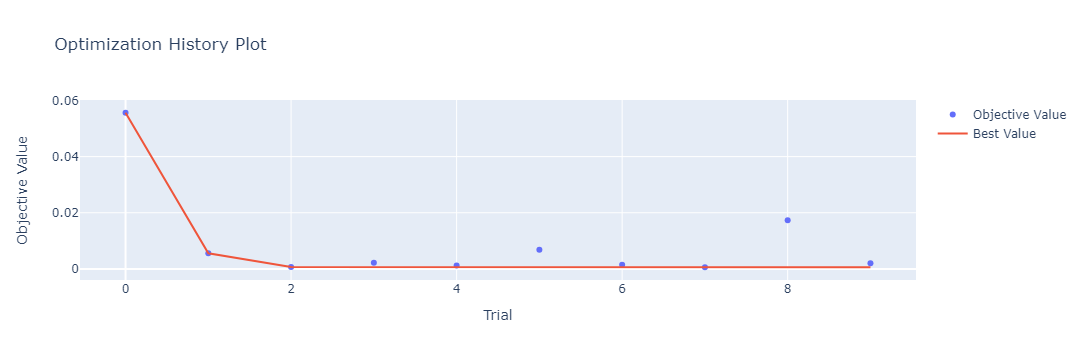

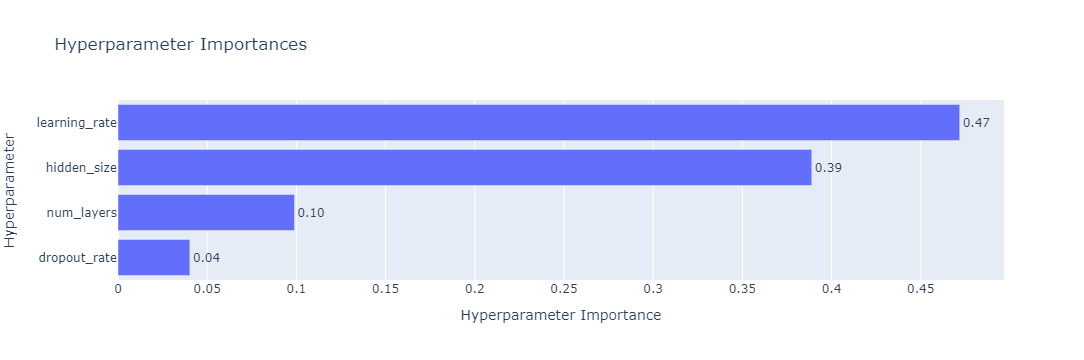

In [7]:
if not skip_optuna:
    def objective(trial):
        # Hyperparameters to tune
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
        hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 264])
        num_layers = trial.suggest_int('num_layers', 1, 3)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

        # Model, criterion, optimizer
        model = SoCCNN1D(input_channels=len(FEATURE_COLS), hidden_channels=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.MSELoss()

        # Train and validate the model
        history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

        # Minimize the last validation loss
        return history['val_loss'][-1]

    # Create study object and perform optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)  

    # Best hyperparameters
    best_hyperparams = study.best_trial.params
    print('Best hyperparameters:', best_hyperparams)

    # Visualize the optimization process
    from optuna.visualization import plot_optimization_history, plot_param_importances

    # Plot optimization history
    optimization_history = plot_optimization_history(study)
    optimization_history.show()

    # Plot hyperparameter importance
    param_importances = plot_param_importances(study)
    param_importances.show()

Best hyperparameters: {'learning_rate': 4.574726163094518e-05, 'hidden_size': 264, 'num_layers': 3, 'dropout_rate': 0.1028583493863014}

### Training

This code block outlines the final stages of a machine learning workflow where the optimal hyperparameters obtained from an Optuna study are used to train a neural network model (SoCCNN1D). The model is trained using the specified input size, hidden layer size, number of layers, and dropout rate. The Adam optimizer is configured with the best learning rate and includes L2 regularization (weight decay). Training and validation losses are computed, plotted over epochs for analysis, and the final model is saved to a .pth file, preserving both the model's learned parameters and the data scaler's parameters.

Epoch 1/50, Train Loss: 0.01679016710890011, Validation Loss: 0.000897132138988734
Time taken for epoch: 59.78275084 seconds
Epoch 2/50, Train Loss: 0.0036560655219339522, Validation Loss: 0.0007735589106199131
Time taken for epoch: 55.38428760 seconds
Epoch 3/50, Train Loss: 0.0036496399840455175, Validation Loss: 0.0007045050888751145
Time taken for epoch: 58.74752450 seconds
Epoch 4/50, Train Loss: 0.0036311056647115162, Validation Loss: 0.0008380023410937585
Time taken for epoch: 60.78818989 seconds
Epoch 5/50, Train Loss: 0.003616453768147546, Validation Loss: 0.000770691425904366
Time taken for epoch: 58.80078220 seconds
Epoch 6/50, Train Loss: 0.00364176216580341, Validation Loss: 0.0006785629940516421
Time taken for epoch: 57.53800416 seconds
Epoch 7/50, Train Loss: 0.0036514740978153245, Validation Loss: 0.0006640131797437644
Time taken for epoch: 60.66377425 seconds
Epoch 8/50, Train Loss: 0.0036487414629552467, Validation Loss: 0.0013260443643205427
Time taken for epoch: 59.

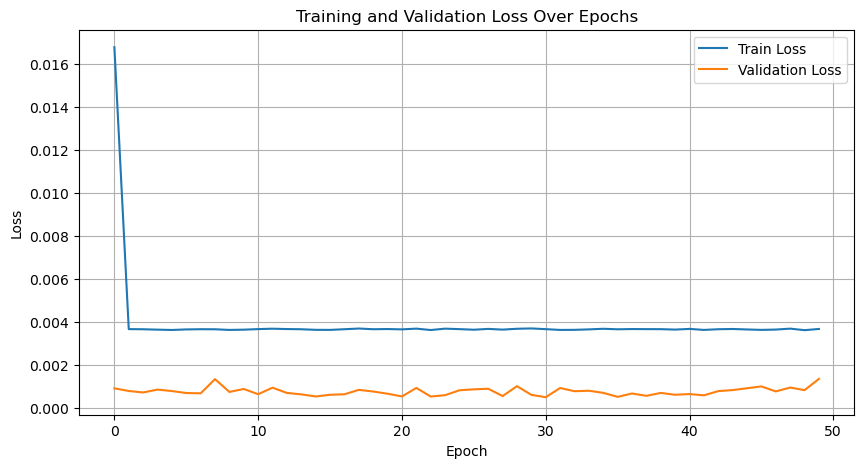

In [8]:
if not skip_training:   
 
    # best_hyperparams = {'learning_rate': 4.574726163094518e-05,'hidden_size': 264, 'num_layers': 3,'dropout_rate': 0.1028583493863014}
    
    # Use 'hidden_size' from 'best_hyperparams' to keep consistency
    hidden_size = best_hyperparams['hidden_size']
    num_layers = best_hyperparams['num_layers']
    dropout_rate = best_hyperparams['dropout_rate']
    
    EPOCHS = 50

    # Train the final model with the best hyperparameters
    model = SoCCNN1D(input_channels=len(FEATURE_COLS), hidden_channels=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=0.01)
    criterion = nn.MSELoss()

    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save the model
    model_path = "soc_cnn_model.pth"
    torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

This code evaluates the performance of a trained neural network model on a test dataset for battery state-of-charge (SOC) prediction. It loads the model, computes predictions on the test set, and then calculates and prints the Mean Squared Error (MSE) and Mean Absolute Error (MAE). Additionally, it plots a scatter graph comparing the true SOC values against the predicted ones, providing a visual representation of the model's accuracy.

Test MSE: 0.001548
Test MAE: 0.032833


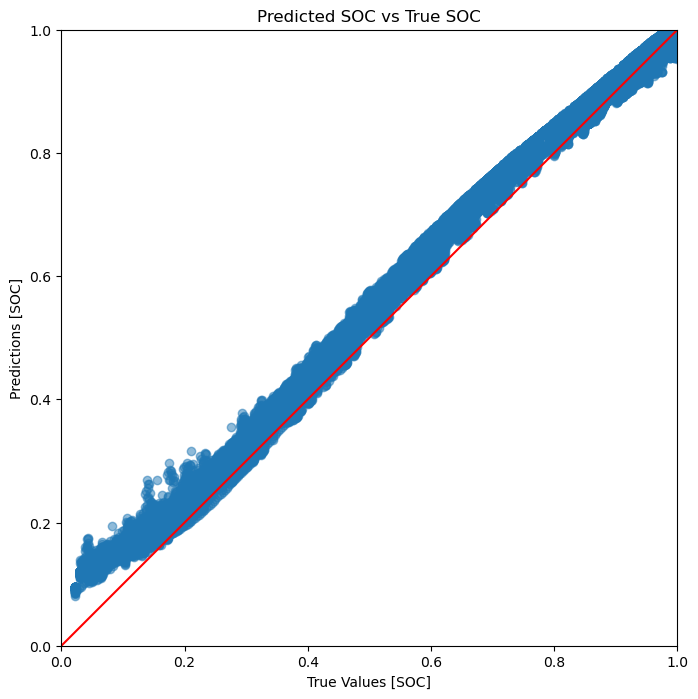

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_path = "soc_cnn_model.pth"

# best_hyperparams = {'learning_rate': 4.574726163094518e-05, 'hidden_size': 264, 'num_layers': 3, 'dropout_rate': 0.1028583493863014}
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']

def load_model(model_path, input_size):
    model = SoCCNN1D(input_channels=input_size, hidden_channels=hidden_size, num_layers=num_layers).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

# Calculate MSE and MAE
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Visualization

This code block is designed to test a machine learning model's performance using a specific dataset file. It reads the test data, including voltage, current, temperature, capacity, and true SoC, then prepares the data for model prediction, excluding the time data. With the model loaded onto the device, it predicts the SoC and plots both the predicted and true SoC, along with voltage, current, temperature, and capacity over time. This visualization allows for an intuitive comparison between the model's predictions and actual measurements.

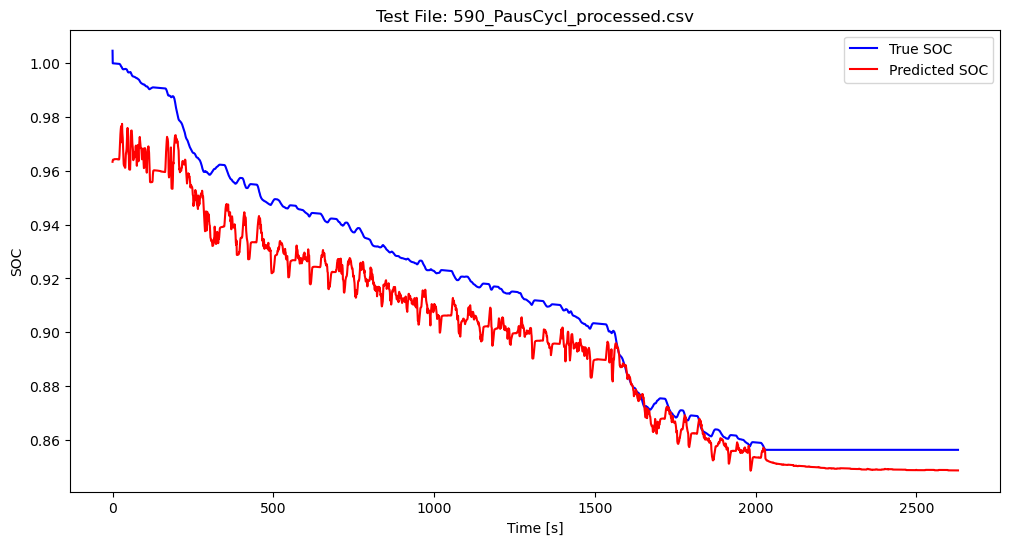

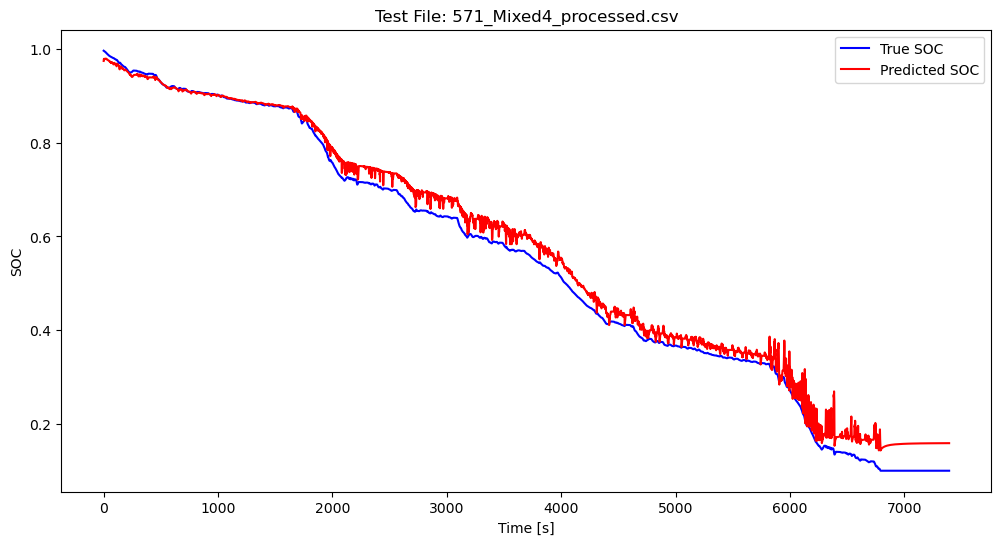

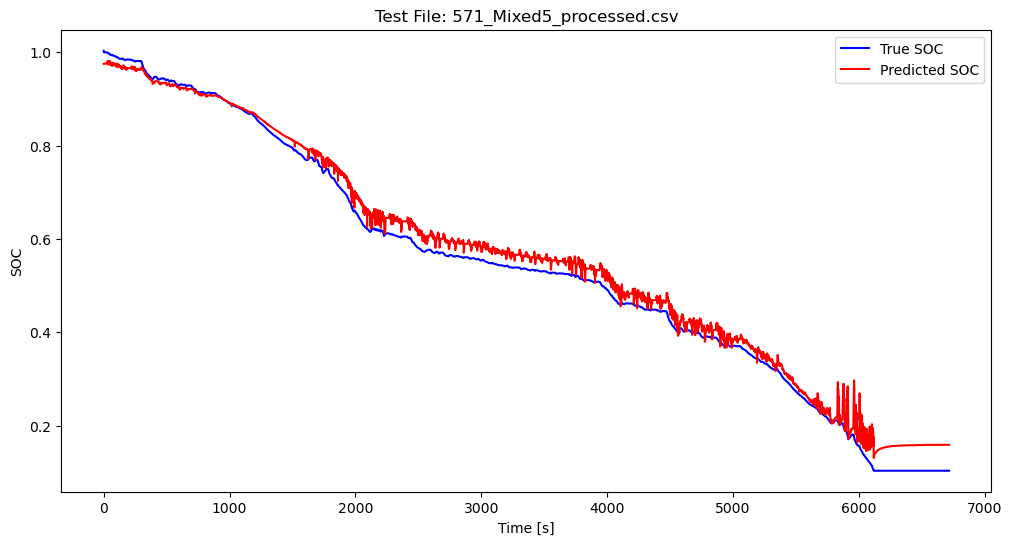

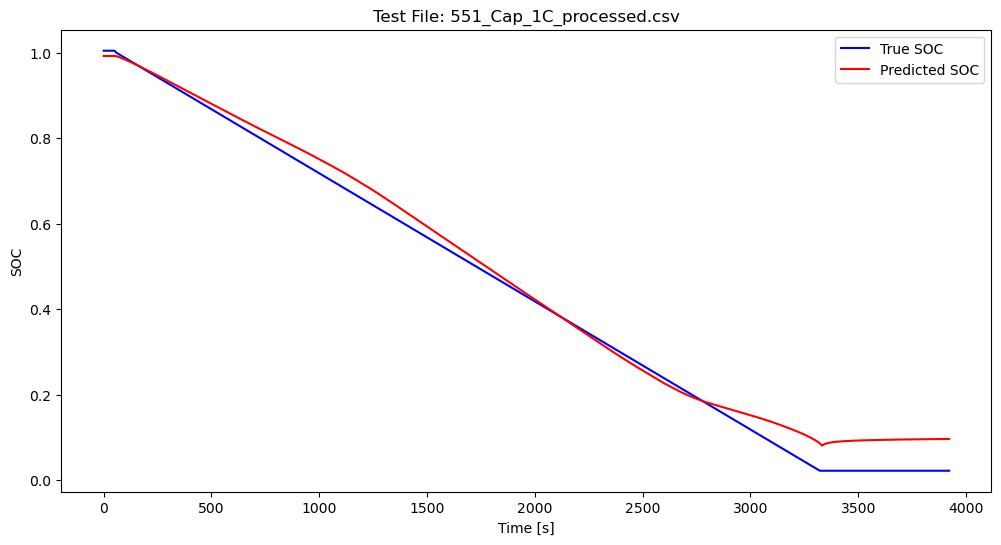

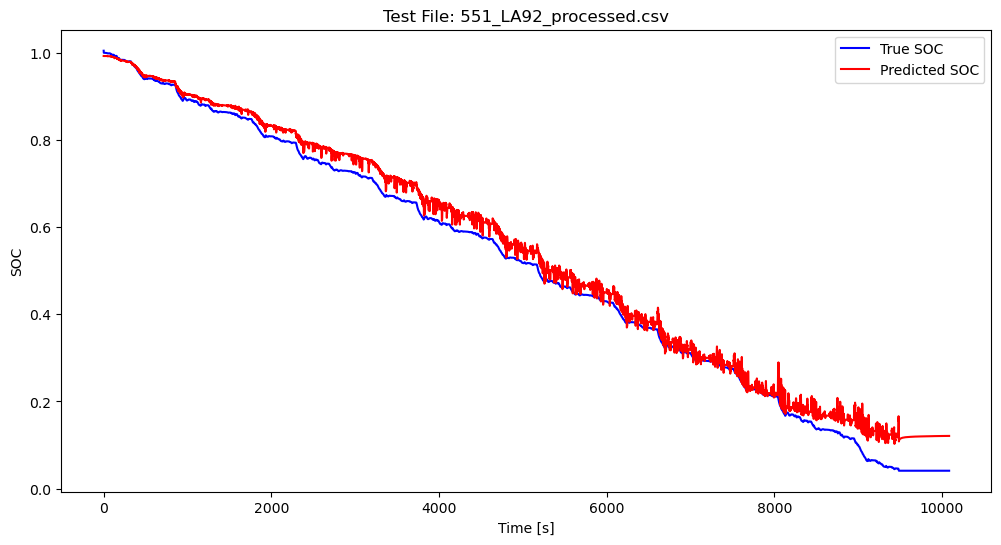

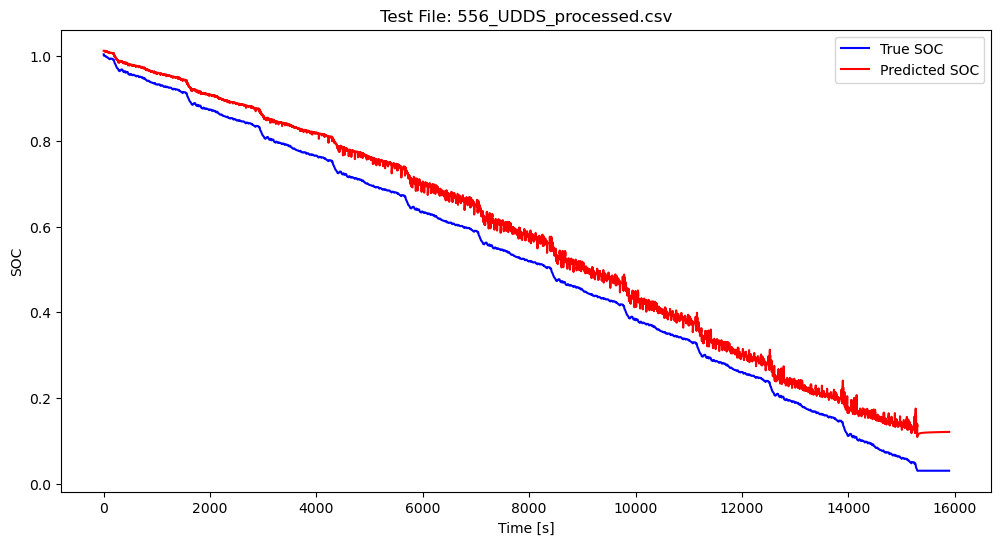

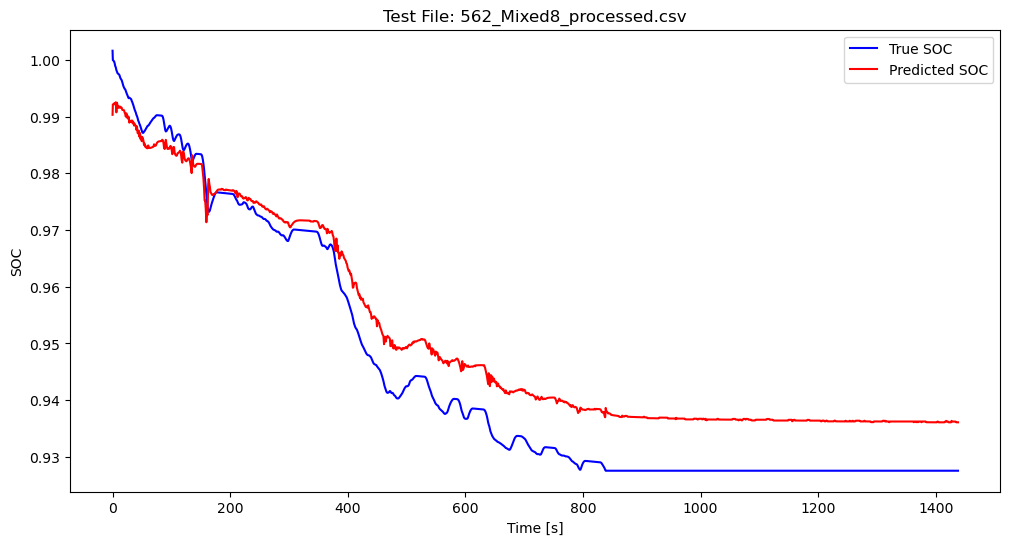

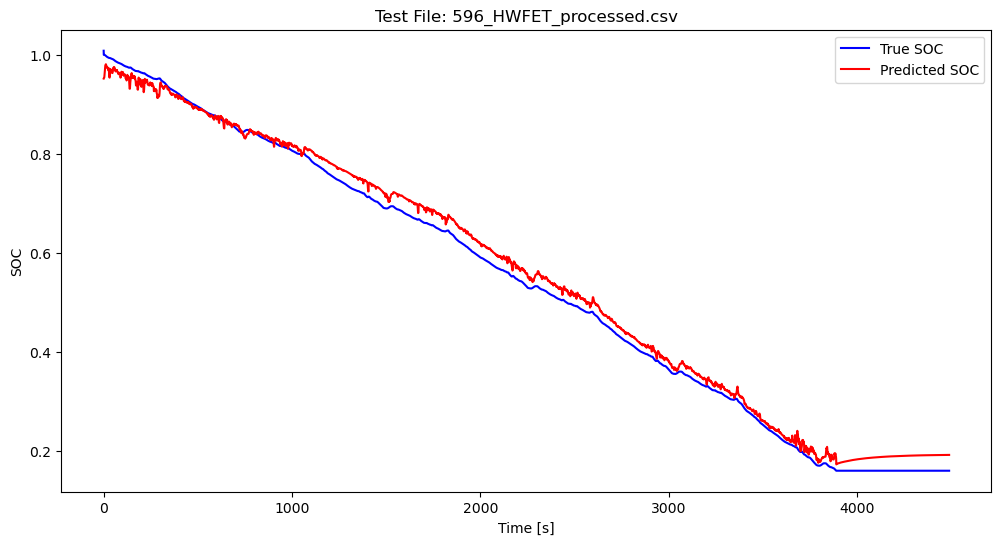

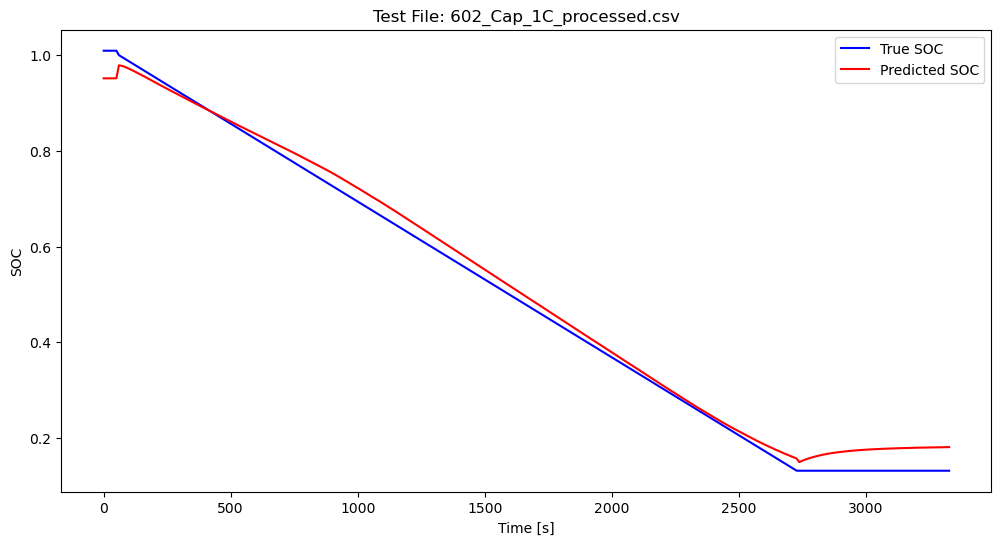

In [23]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)